1. Get all correlations from the DepMap above some threshold. DONE
2. Get statements from Bioexp corpus, stratify by DBs vs. reading
3. Count correlations explained in the two cases
4. Highlight examples of complexes, mods, act/neg regulation etc. due to additional info
5. Look at DepMap overlap vs. belief score

In [94]:
import pickle
import random
import itertools
from os.path import join
import xswap
import numpy as np
import pandas as pd
from tqdm import tqdm
import networkx as nx
from collections import defaultdict
from matplotlib import pyplot as plt
from indra.statements import Complex, Phosphorylation, RegulateActivity, RegulateAmount, pretty_print_stmts as pps
from indra.preassembler import flatten_stmts
from indra.tools import assemble_corpus as ac
from indra.sources.biogrid import BiogridProcessor
from indra.assemblers.indranet import IndraNetAssembler
from depmap_analysis.scripts.depmap_script2 import main as run_depmap
from indra.ontology.bio import bio_ontology as bo
from indra.preassembler import Preassembler
from scipy.special import ndtri_exp

from depmap_analysis.network_functions.net_functions import sif_dump_df_to_digraph
from multiprocessing import Pool
import logging

from indra.belief.skl import CountsScorer
from sklearn.ensemble import RandomForestClassifier
from bioexp.curation.classifiers import LogLogisticRegression, BinaryRandomForest
import seaborn as sns
from bioexp.util import format_axis, fontsize
from depmap_analysis.scripts.depmap_script2 import mito_file
from depmap_analysis.network_functions.depmap_network_functions import get_pairs

import upsetplot
from venn import venn


%matplotlib notebook

opath = '../output/'
prefix = 'fig6_ipynb'

def fig_path(name, fmt):
    return join(opath, f'{prefix}_{name}.{fmt}')

logger = logging.getLogger('depmap_benchmark')

Path to DepMap correlation Z-scores (computed in the Jupyter notebook `depmap_analysis/notebooks/Biomarkers of Dependency.ipynb`):

In [22]:
depmap_basedir = '/Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism' \
                 '/datasets/depmap_analysis/depmap/21q2'
depmap_corr_file = join(depmap_basedir, 'dep_z.h5')

## Load the statements and curation data and train the model

In [3]:
def load_curation_data(filename):
    with open(filename, 'rb') as f:
        dataset = pickle.load(f)
        df = pd.DataFrame.from_records(dataset)
        df = df.fillna(0)
    # Every column except agent names and stmt type should be int
    dtype_dict = {col: 'int64' for col in df.columns
                  if col not in ('agA_name', 'agA_ns', 'agA_id', 'stmt_type',
                                 'agB_name', 'agB_ns', 'agB_id')}
    df = df.astype(dtype_dict)
    return df

# Get dataset of curated statements along with correctness values
def stmts_for_df(df, stmts_by_hash):
    stmt_list = []
    for row in kge_df.itertuples():
        stmt_hash = row.stmt_hash
        if stmt_hash not in stmts_by_hash:
            continue
        stmt_list.append(stmts_by_hash[stmt_hash])
    return stmt_list


# Load pickle of assembled statements.
all_stmts = ac.load_statements('../data/bioexp_asmb_preassembled.pkl')

INFO: [2021-07-30 09:12:29] indra.tools.assemble_corpus - Loading ../data/bioexp_asmb_preassembled.pkl...
INFO: [2021-07-30 09:13:34] indra.tools.assemble_corpus - Loaded 895580 statements


In [4]:
def filter_stmts(stmts, genes_only=False):
    stmts = ac.filter_genes_only(stmts, specific_only=genes_only)
    stmts = ac.filter_human_only(stmts)
    stmts = [s for s in stmts if None not in s.agent_list()]
    stmts = [s for s in stmts if None not in [ag.name for ag in s.agent_list()]]
    return stmts

all_stmts = filter_stmts(all_stmts, genes_only=False)
all_stmts_genes = filter_stmts(all_stmts, genes_only=True)

INFO: [2021-07-30 09:13:34] indra.tools.assemble_corpus - Filtering 895580 statements for ones containing genes only...
INFO: [2021-07-30 09:13:39] indra.tools.assemble_corpus - 895580 statements after filter...
INFO: [2021-07-30 09:13:39] indra.tools.assemble_corpus - Filtering 895580 statements for human genes only...
INFO: [2021-07-30 09:14:00] indra.tools.assemble_corpus - 895553 statements after filter...
INFO: [2021-07-30 09:14:03] indra.tools.assemble_corpus - Filtering 814991 statements for ones containing genes only...
INFO: [2021-07-30 09:14:06] indra.tools.assemble_corpus - 618362 statements after filter...
INFO: [2021-07-30 09:14:06] indra.tools.assemble_corpus - Filtering 618362 statements for human genes only...
INFO: [2021-07-30 09:14:14] indra.tools.assemble_corpus - 618362 statements after filter...


In [5]:
len(all_stmts_genes)

618362

For a database-only comparison, we filter to the statements that have any DB evidence from the sources above:

In [6]:
db_stmts = ac.filter_evidence_source(all_stmts, ['bel', 'biopax', 'hprd', 'signor', 'trrust'])

INFO: [2021-07-30 09:14:16] indra.tools.assemble_corpus - Filtering 814991 statements to evidence source "one" of: bel, biopax, hprd, signor, trrust...
INFO: [2021-07-30 09:14:18] indra.tools.assemble_corpus - 132924 statements after filter...


In [7]:
len(db_stmts)

132924

In [8]:
import mplayer
p = mplayer.Player()
success_file = '/Users/johnbachman/Downloads/success.m4a'
p.loadfile(success_file)

In [9]:
stmts_by_hash = {s.get_hash(): s for s in all_stmts}
# Load the curated data
curation_data_file = 'curation_dataset_with_bg_psp.pkl'
kge_df = load_curation_data(curation_data_file)
# Get statements from curation dataframe
kge_stmts = stmts_for_df(kge_df, stmts_by_hash)
y_arr = kge_df['correct'].values

In [10]:
stmts_y = list(zip(kge_stmts, y_arr))

## Train the model

Sources in training data:

In [11]:
all_sources = list(set([ev.source_api for stmt in kge_stmts for ev in stmt.evidence]))
all_sources

['trips',
 'medscan',
 'trrust',
 'hprd',
 'reach',
 'bel',
 'signor',
 'isi',
 'biopax',
 'rlimsp',
 'sparser']

In [12]:
# Create a CountsModel for this type of classifier
clf = RandomForestClassifier(n_estimators=2000, max_depth=13)
model = CountsScorer(clf, all_sources, use_stmt_type=True, use_num_pmids=True)

# Use instance of CountsModel to get feature data as a matrix
# with appropriate featurization
model.fit(kge_stmts, y_arr)

beliefs = model.predict_proba(all_stmts)[:, 1]
for ix, stmt in enumerate(all_stmts):
    stmt.belief = beliefs[ix]
    
#with open('../output/trained_loglogreg.pkl', 'rb') as f:
#    llr_model = pickle.load(f)
#source_list = ['reach', 'sparser', 'medscan', 'rlimsp', 'trips']
#cm = CountsModel(llr_model, source_list)

# Task 1: Using prior to control FDR in hypothesis testing

## Process the statements to determine which gene pairs will be used in testing:

In [13]:
len(all_stmts_genes)

618362

In [14]:
all_stmts_2 = [s for s in all_stmts_genes if len(s.agent_list()) == 2]

In [15]:
len(all_stmts_2)

575797

For a fair comparison, filter out any statements that are explicitly between mitochondrial genes (because we said we weren't going to consider those for explanation:

In [16]:
mitocarta = pd.read_excel('../../depmap_analysis/notebooks/data/Human.MitoCarta3.0.xls', sheet_name=1)
mitogenes = list(mitocarta.Symbol.values)

In [17]:
all_stmts_nm = ac.filter_gene_list(all_stmts_2, mitogenes, policy='all', invert=True)

INFO: [2021-07-30 09:59:12] indra.tools.assemble_corpus - Filtering 575797 statements for ones not containing "all" of: CYC1, SDHB, COQ7, SDHA, UQCRC1, COQ5, PDHA1, COQ9, MRPL12, ATP5F1D, COX5A, ISCA2, PMPCB, UQCRFS1, ATP5F1A, OGDH, PDHB, UQCRC2, SDHD, MRPS35, UQCRQ, MRPL53, DBT, PDK4, MDH2, MRPS27, CS, GRPEL1, DLAT, LRPPRC, DLST, PDHX, GFM1, MPC2, NDUFS1, MRPL46, ATP5F1E, SLC25A3, MRPS23, FH, PMPCA, ATP5F1B, SDHAF4, UQCR10, ISCA1, SUCLA2, COQ3, IARS2, MRPS15, IDH3A, COX11, ETFDH, TIMM10, MRPL34, MRPL2, BCKDHA, UQCRH, HIGD2A, ATP5PO, ECHS1, LETMD1, COX6A1, COX15, AFG3L2, HADHA, ETFA, NDUFS7, CPT2, BCKDHB, IDH3B, LARS2, ACADS, LETM1, ATP5ME, OPA1, AUH, SUCLG1, NDUFV2, COQ6, MRPL43, ABHD11, ATP5PF, NDUFB8, LONP1, DLD, AIFM1, ECHDC3, APOOL, MRPL10, MRRF, NDUFS8, ACADM, IMMT, TIMM9, SLC25A4, SAMM50, NDUFS2, NDUFV1, ACO2, SUPV3L1, FECH, MTIF2, PHB, HIBCH, MRPS2, HSPA9, SURF1, PRDX3, GHITM, GUF1, TIMM13, LYRM4, MRPL16, MRPL40, IDH3G, SDHC, NDUFB5, SDHAF2, COQ10A, GATD3A, TXN2, MRPS18A, COX6C

INFO: [2021-07-30 09:59:27] indra.tools.assemble_corpus - 571377 statements after filter...


In [18]:
len(all_stmts_nm)

571377

Specify which set of statements we're using for explanation:

In [19]:
stmts_comps = all_stmts_nm

Load the combined p-values from the DepMap data:

In [23]:
filename = 'dep_logp'
#filename = 'crispr_logp'
z_filepath = join(depmap_basedir, '%s.h5' % filename)
df_logp = pd.read_hdf(z_filepath)

INFO: [2021-07-30 10:34:16] numexpr.utils - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: [2021-07-30 10:34:16] numexpr.utils - NumExpr defaulting to 8 threads.


Get the statement gene pairs where the genes are in the dataset, and are not self-loops:

In [24]:
stmt_tuples = set()
stmts_by_gene_pair = defaultdict(list)
df_agents = set(df_logp.index)
for stmt in stmts_comps:
    agent_names = tuple(sorted([ag.name for ag in stmt.agent_list()]))
    # Ignore self-loops
    if agent_names[0] == agent_names[1]:
        continue
    # Make sure both agents in the statement are in the original dataset
    if not agent_names[0] in df_agents or not agent_names[1] in df_agents:
        continue
    stmts_by_gene_pair[agent_names].append(stmt)
    stmt_tuples.add(agent_names)
stmts_by_gene_pair = dict(stmts_by_gene_pair)

In [25]:
len(stmt_tuples)

265874

Calculate the threshold Bonferroni-corrected p-value threshold:

In [26]:
num_comps = len(stmt_tuples)
alpha = 0.05
bc_thresh = np.log(alpha / num_comps)
bc_thresh

-15.486510064883495

How many p-values at this lower cutoff?

In [27]:
def unstack_corrs(df):
    df_ut = df.where(np.triu(np.ones(df.shape), k=1).astype(np.bool))
    stacked: pd.DataFrame = df_ut.stack(dropna=True)
    return stacked

In [28]:
unstack_corrs(df_logp[df_logp < bc_thresh])

/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


A1BG     ABHD16B    -20.361093
         AP2A1      -15.849796
         APOE       -23.732153
         ARHGAP33   -16.941965
         BLVRB      -20.676842
                       ...    
ZSCAN1   ZSCAN18    -19.856676
ZSCAN16  ZSCAN31    -19.661376
ZSWIM1   ZSWIM3     -20.776980
ZWILCH   ZWINT      -26.154191
ZXDA     ZXDB       -17.517685
Length: 312858, dtype: float64

## Counting/summarizing correlations identified as significant with prior

Get the full set below alpha:

In [29]:
# Load the significant (corrected) gene pairs from the DepMap directory:
sig_corrs_file = 'dep_stouffer_signif.pkl'
data_sig_corrs = pd.read_pickle(join(depmap_basedir, sig_corrs_file))
data_sig_corrs

,,logp,rank,bc_cutoff,bh_crit_val,by_crit_val
geneA,geneB,,,,,
TSC1,TSC2,-inf,1.0,-21.585531,-21.585531,-24.538721
MDM2,TP53,-659.890484,2.0,-21.585531,-20.892383,-23.845574
AP2M1,AP2S1,-508.765692,3.0,-21.585531,-20.486918,-23.440109
GRB2,PTPN11,-473.818533,4.0,-21.585531,-20.199236,-23.152427
AP2M1,TFRC,-441.275034,5.0,-21.585531,-19.976093,-22.929284
...,...,...,...,...,...,...
B4GALNT2,NME3,-2.995733,21526507.0,-21.585531,-4.700735,-7.653926
DGAT2,SLC12A6,-2.995732,21526508.0,-21.585531,-4.700735,-7.653926
PGM2,SLC26A3,-2.995732,21526509.0,-21.585531,-4.700735,-7.653926


In [30]:
def sig_corr_stats(data_corrs, alpha, stmt_tuples, total_comps):        
    # The number of comparisons using the prior
    indra_comps = len(stmt_tuples)
    # Add a column to the correlation list indicating whether the gene pair
    # is in the prior
    data_corrs['in_prior'] = data_corrs.index.isin(stmt_tuples)
    # Get the gene pairs in the prior with p values
    indra_sig_corrs = data_corrs[data_corrs['in_prior']]['logp']
    # Sort by p values
    sig_sorted = indra_sig_corrs.sort_values().to_frame('logp')
    # Add rank column for BH and BY correction
    sig_sorted['rank'] = sig_sorted.rank()
    num_comps = len(stmt_tuples)
    # Calculate BC threshold for hypotheses in prior
    bc_thresh = np.log(alpha / indra_comps)
    # Add column for BC p-value threshold
    sig_sorted['bc_cutoff'] = bc_thresh
    # Add the Benjamini-Hochberg critical value
    sig_sorted['bh_crit_val'] = np.log((sig_sorted['rank'] / indra_comps) * alpha)
    # Get the harmonic number
    cm = np.log(indra_comps) + np.euler_gamma + (1/(2*indra_comps))
    # Calculate the BY critical value
    sig_sorted['by_crit_val'] = sig_sorted['bh_crit_val'] - np.log(cm)
    
    # Start to fill out correlation stats table
    stats_data_cols = ['No prior', 'INDRA prior (all)', 'INDRA prior (only)']
    stats_data_rows = ['Total correlations',
                       'Num. comparisons (non-mitochondrial)',
                       'Correlations with uncorrected p < 0.05',
                       'Significant corrs after Bonferroni',
                       'Significant corrs after Benjamini-Hochberg',
                       'Significant corrs after Benjamini-Yekutieli']
    nan = None
    # First row: the total number of correlations
    stats_data = [(total_comps, nan, nan)]
    # Second row: the total number of comparisons
    stats_data.append((total_comps, indra_comps))
    # Third row: number of uncorrected significant correlations
    stats_data.append((len(data_corrs), len(indra_sig_corrs), nan))
    # Fourth row: significant correlations after Bonferroni correction
    data_bc = data_corrs[data_corrs['logp'] < data_corrs['bc_cutoff']]
    indra_bc = sig_sorted[sig_sorted['logp'] < sig_sorted['bc_cutoff']]
    indra_only_bc = set(indra_bc.index).difference(set(data_bc.index))
    stats_data.append((len(data_bc), len(indra_bc), len(indra_only_bc)))
    # Fifth row: significant correlations after BH correction
    data_bh = data_corrs[data_corrs['logp'] < data_corrs['bh_crit_val']]
    indra_bh = sig_sorted[sig_sorted['logp'] < sig_sorted['bh_crit_val']]
    indra_only_bh = set(indra_bh.index).difference(set(data_bh.index))
    stats_data.append((len(data_bh), len(indra_bh), len(indra_only_bh)))
    # Sixth row: significaant correations after BY correction
    data_by = data_corrs[data_corrs['logp'] < data_corrs['by_crit_val']]
    indra_by = sig_sorted[sig_sorted['logp'] < sig_sorted['by_crit_val']]
    indra_only_by = set(indra_by.index).difference(set(data_by.index))
    stats_data.append((len(data_by), len(indra_by), len(indra_only_by)))
    stats_data_df = pd.DataFrame(stats_data, index=stats_data_rows, columns=stats_data_cols)
    # Use the Int64 datatype for integer column with missing values
    stats_data_df = stats_data_df.astype({'INDRA prior (all)': 'Int64',
                                          'INDRA prior (only)': 'Int64'})
    # INDRA only BY dataframe:
    indra_only_by_df = indra_by[indra_by.index.isin(indra_only_by)]
    
    return {'summary': stats_data_df, 'indra_corrs': sig_sorted, 'indra_only_by': indra_only_by_df}
    
alpha = 0.05
stmt_tuples = list(stmt_tuples)
total_comps = 121778711
corr_res = sig_corr_stats(data_sig_corrs, alpha, stmt_tuples, total_comps)

In [31]:
corr_res['summary']

,No prior,INDRA prior (all),INDRA prior (only)
Total correlations,121778711,<NA>,<NA>
Num. comparisons (non-mitochondrial),121778711,265874,<NA>
Correlations with uncorrected p < 0.05,21526511,63926,<NA>
Significant corrs after Bonferroni,99487,4982,1836
Significant corrs after Benjamini-Hochberg,5011276,30127,7543
Significant corrs after Benjamini-Yekutieli,971149,12812,4016


In [32]:
import mplayer
p = mplayer.Player()
success_file = '/Users/johnbachman/Downloads/success.m4a'
p.loadfile(success_file)

## Cherry-picking the INDRA only gene pairs

Rank INDRA-only gene pairs by belief score:

In [33]:
def add_sources_and_belief(df):
    gene_pair_beliefs = defaultdict(list)
    readers = set(['reach', 'sparser', 'medscan', 'rlimsp', 'trips'])
    gp_index = df.index
    data = []
    for gene_pair in gp_index:
        stmts = stmts_by_gene_pair[gene_pair]
        sources = set([ev.source_api for stmt in stmts for ev in stmt.evidence])
        beliefs = [stmt.belief for stmt in stmts]
        if not sources.difference(readers):
            reading_only = True
        else:
            reading_only = False
        max_bel = max(beliefs)
        data.append((reading_only, max_bel))
    src_bel = pd.DataFrame(data, index=gp_index, columns=('reading_only', 'max_belief'))
    return df.join(src_bel)

Collect additional information about INDRA-only correlations:

In [34]:
indra_only_df = add_sources_and_belief(corr_res['indra_only_by'])

In [35]:
crispr_corr_file = join(depmap_basedir, 'crispr_correlations.h5')
crispr_corr = pd.read_hdf(crispr_corr_file)
rnai_corr_file = join(depmap_basedir, 'rnai_correlations.h5')
rnai_corr = pd.read_hdf(rnai_corr_file)

In [36]:
def add_correlations(df, corr_df, corr_type):
    data = []
    for geneA, geneB in df.index:
        corr = corr_df[geneA][geneB]
        data.append((corr, abs(corr)))
    corr_basename = f'{corr_type}_corr'
    corrs = pd.DataFrame(data, index=df.index,
                         columns=(corr_basename, f'{corr_basename}_abs'))
    return df.join(corrs)        

In [37]:
def add_stmt_polarity(df, stmts_by_gene_pair):
    pols = []
    for geneA, geneB in df.index:
        has_pol = False
        ab_stmts = stmts_by_gene_pair[(geneA, geneB)]
        for stmt in ab_stmts:
            if isinstance(stmt, RegulateActivity) or isinstance(stmt, RegulateAmount):
                has_pol = True
        pols.append(has_pol)
    pols_df = pd.DataFrame(pols, index=df.index, columns=['has_stmt_polarity'])
    return df.join(pols_df)

In [38]:
indra_only_df = add_correlations(indra_only_df, crispr_corr, 'crispr')
indra_only_df = add_correlations(indra_only_df, rnai_corr, 'rnai')
indra_only_df = add_stmt_polarity(indra_only_df, stmts_by_gene_pair)

Correlations supported only by reading:

In [39]:
ronly = indra_only_df[indra_only_df.reading_only]

In [40]:
nonpolar = ronly[ronly.has_stmt_polarity == False]
nonpolar[(nonpolar.crispr_corr < 0) & (nonpolar.rnai_corr < 0)].sort_values(
    by='max_belief', ascending=False).sort_values(
    by='crispr_corr')[0:50]

,,logp,rank,bc_cutoff,bh_crit_val,by_crit_val,reading_only,max_belief,crispr_corr,crispr_corr_abs,rnai_corr,rnai_corr_abs,has_stmt_polarity
geneA,geneB,,,,,,,,,,,,
CHEK2,PALB2,-10.722479,8837.0,-15.48651,-6.399807,-8.969973,True,0.434801,-0.173407,0.173407,-0.021845,0.021845,False
BLM,PRKAR1A,-8.973073,11917.0,-15.48651,-6.100789,-8.670955,True,0.149322,-0.163352,0.163352,-0.009480,0.009480,False
EIF2AK4,MTOR,-9.226638,11370.0,-15.48651,-6.147776,-8.717943,True,0.777481,-0.155121,0.155121,-0.022714,0.022714,False
CPT1A,NLRP3,-10.661590,8926.0,-15.48651,-6.389786,-8.959953,True,0.149322,-0.152056,0.152056,-0.050325,0.050325,False
ASF1B,CDAN1,-10.132518,9694.0,-15.48651,-6.307248,-8.877414,True,0.149322,-0.148788,0.148788,-0.048725,0.048725,False
NRP1,SRC,-9.400214,11001.0,-15.48651,-6.180769,-8.750935,True,0.777481,-0.148001,0.148001,-0.033533,0.033533,False
PRC1,YY1,-10.336882,9368.0,-15.48651,-6.341455,-8.911621,True,0.134182,-0.147568,0.147568,-0.073841,0.073841,False
ERBB2,STMN1,-8.692865,12576.0,-15.48651,-6.046965,-8.617131,True,0.876954,-0.146075,0.146075,-0.038289,0.038289,False
JUN,MCL1,-10.462106,9203.0,-15.48651,-6.359225,-8.929391,True,0.434801,-0.141125,0.141125,-0.054864,0.054864,False


In [41]:
pps(stmts_by_gene_pair[('GRB10', 'IRS2')])

[LIST INDEX: 0] Complex(GRB10(), IRS2())
EV INDEX: 0       Furthermore, GRB10 associated with IRS-2, NEDD4.2 (an E3-ubiquitin ligase), IL-4Rα, and γC after IL-4
SOURCE: medscan   stimulation.
PMID: 27742835
------------------------------------------------------------------------------------------------------------------------
EV INDEX: 1       Furthermore, GRB10 associated with IRS-2, NEDD4.2 (an E3-ubiquitin ligase), IL-4Rα, and γC after IL-4
SOURCE: sparser   stimulation.
PMID: 27742835
------------------------------------------------------------------------------------------------------------------------
EV INDEX: 2       Furthermore, GRB10 associated with IRS-2, NEDD4.2 (an E3-ubiquitin ligase), IL-4Rα, and γC after IL-4
SOURCE: trips     stimulation.
PMID: TEXT00003_
RT00038436
------------------------------------------------------------------------------------------------------------------------
EV INDEX: 3       Furthermore, GRB10 associated with IRS-2, NEDD4.2 (an E3-ubiquitin 

# Task 2: Explaining correlations

## Build INDRA networks (DB-only and all sources)

Set up metadata for building randomized and non-randomized IndraNets.

In [42]:
# Statement corpus, all vs. db, randomized or not, 
stmt_lists = {'all': all_stmts, 'db': db_stmts}
corpus_types = ('all', 'db')
graph_meta = {}
for corpus_type in corpus_types:
    graph_meta[corpus_type] = {}
    for rand_type in ('norand', 'randxswap', 'randlabels'):
        graph_meta[corpus_type][rand_type] = f'bioexp_depmap_{corpus_type}_stmts_{rand_type}_inet.pkl'
graph_meta

{'all': {'norand': 'bioexp_depmap_all_stmts_norand_inet.pkl',
  'randxswap': 'bioexp_depmap_all_stmts_randxswap_inet.pkl',
  'randlabels': 'bioexp_depmap_all_stmts_randlabels_inet.pkl'},
 'db': {'norand': 'bioexp_depmap_db_stmts_norand_inet.pkl',
  'randxswap': 'bioexp_depmap_db_stmts_randxswap_inet.pkl',
  'randlabels': 'bioexp_depmap_db_stmts_randlabels_inet.pkl'}}

In [43]:
# This function uses the Xswap module to permuted the edges of the
# network while maintaining the degree distribution of the original
# nodes (so, e.g. TP53 will have exactly the same degree in the
# shuffled network as the original network)
def shuffle_xswap(net, seed=1):
    node_to_int = {}
    int_to_node = {}
    for ix, node in enumerate(net.nodes):
        node_to_int[node] = ix
        int_to_node[ix] = node
    # Relabel edges as integers to pass to xswap
    relabeled_edges = [(node_to_int[u], node_to_int[v]) for u, v in net.edges]    
    # Shuffle edges using xswap
    permuted_edges_int, permutation_stats = xswap.permute_edge_list(
                    relabeled_edges, allow_self_loops=True, allow_antiparallel=True,
                    multiplier=10, seed=seed)
    # Relabel edges again as ints
    permuted_edges_node = [(int_to_node[u], int_to_node[v])
                           for u, v in permuted_edges_int]
    shuf_net = nx.DiGraph()
    # Add the node names with associated namespace/ID info
    shuf_net.add_nodes_from(net.nodes(data=True))
    # Add the permuted edges
    shuf_net.add_edges_from(permuted_edges_node)
    # Add the graph NS/ID lookup metadata
    shuf_net.graph['node_by_ns_id'] = net.graph['node_by_ns_id']
    return shuf_net

In [44]:
# This function simply relabels the nodes in the network
def shuffle_labels(net, seed=1):
    random.seed(1)
    shuf_nodes = list(inet.nodes())
    random.shuffle(shuf_nodes)
    old_to_new = {old: new for old, new in zip(inet.nodes(), shuf_nodes)}
    shuf_net = nx.relabel.relabel_nodes(inet, old_to_new, copy=True)
    return shuf_net    

Build randomized and non-randomized IndraNets from the statements. Takes about 11 minutes.

In [45]:
recalculate = False

if recalculate: 
    graph_type = 'digraph' # 'multi_graph', 'digraph' or 'signed'
    for corpus_type, corpus_dict in graph_meta.items():
        stmts = stmt_lists[corpus_type]
        # First, make the network without randomization
        ina = IndraNetAssembler(statements=stmts)
        #inet = ina.make_model(complex_members=3, graph_type=graph_type)
        sif_df = ina.make_df(complex_members=3)
        inet = sif_dump_df_to_digraph(df=sif_df, date='20210722')
        no_rand_output_file = corpus_dict['norand']
        print(f"Saving {corpus_type} base network")
        with open(no_rand_output_file, 'wb') as f:
            pickle.dump(inet, f)
        # Next, shuffle the edges to make a new network and save to
        # the randomized output file
        randxswap_inet = shuffle_xswap(inet, seed=1)
        rand_output_file = corpus_dict['randxswap']
        print(f"Saving {corpus_type} randxswap")
        with open(rand_output_file, 'wb') as f:
            pickle.dump(randxswap_inet, f)
        # Finally, shuffle the labels to produce an alternative
        # randomization
        randlabels_inet = shuffle_labels(inet, seed=1)
        rand_output_file = corpus_dict['randlabels']
        print(f"Saving {corpus_type} randlabels")
        with open(rand_output_file, 'wb') as f:
            pickle.dump(randlabels_inet, f)

In [46]:
import mplayer
p = mplayer.Player()
success_file = '/Users/johnbachman/Downloads/success.m4a'
p.loadfile(success_file)

## Run explanations

Define the bin boundaries that we will use to aggregate correlations:

In [47]:
corr_range = np.linspace(0, 16, 33)
corr_bins = []
for ix in range(len(corr_range)):
    corr_lb = corr_range[ix]
    corr_ub = None if (ix + 1) >= len(corr_range) \
                   else corr_range[ix + 1]
    corr_bins.append((corr_lb, corr_ub))

Get counts of correlations in each bin. We need this both as a denominator to determine percentage of correlations explained, as well as to efficiently determine whether we need to use sampling because the number of correlations is very large:

In [48]:
corr_bin_ct_file = 'dep_corr_bin_counts.pkl'

recalculate = False

if recalculate:
    corr_bin_counts = []
    logger.info("Loading correlations")
    dep_z = pd.read_hdf(depmap_corr_file)    
    for corr_lb, corr_ub in corr_bins:
        logger.info(f"Filtering correlation matrix to range {(corr_lb, corr_ub)}")
        if corr_ub is None:
            dep_subset = dep_z[dep_z.abs() >= corr_lb]
        else:
            dep_subset = dep_z[(dep_z.abs() >= corr_lb) &
                               (dep_z.abs() < corr_ub)]
        logger.info("Counting correlations for bin")
        bin_count = get_pairs(dep_subset)
        corr_bin_counts.append(((corr_lb, corr_ub), bin_count))
    with open(corr_bin_ct_file, 'wb') as f:
        pickle.dump(corr_bin_counts, f)
else:
    logger.info(f"Loading correlation counts from {corr_bin_ct_file}")
    with open(corr_bin_ct_file, 'rb') as f:
        corr_bin_counts = pickle.load(f)

INFO: [2021-07-30 10:40:42] depmap_benchmark - Loading correlation counts from dep_corr_bin_counts.pkl


In [49]:
expl_funcs = ('expl_ab', 'expl_ba', 'find_cp', 'apriori_explained',
              'parent_connections', 'common_reactome_paths')
#expl_funcs = ('expl_ab', 'expl_ba')
max_pairs = 1000000
expl_meta = {}
for source_type, source_dict in graph_meta.items():
    for do_rand, inet_file in source_dict.items():
        for (corr_lb, corr_ub), count in reversed(corr_bin_counts):
            expl_key = (source_type, do_rand, corr_lb, corr_ub)
            expl_meta[expl_key] = (inet_file,
                                   f'bioexp_depmap_{source_type}_{do_rand}_{corr_lb}_{corr_ub}', count)

A wrapper around the explainer script main function to handle arg preprocessing:

In [50]:
def run_depmap_wrapper(inet_file, output_file, sd_range, count):
    reactome_file = '/Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/' \
                'datasets/depmap_analysis/reactome_pathways.pkl'
    if count > 1000000:
        sample_size=1000000
    else:
        sample_size=None
    run_depmap(inet_file, depmap_corr_file, output_file, 'unsigned', sd_range,
               sample_size=sample_size, apriori_explained=mito_file,
               reactome_path=reactome_file,
               overwrite=True, depmap_date='21q1', expl_funcs=expl_funcs,
               n_chunks=1)

Clear up some memory:

del all_stmts
del stmts_by_hash
del kge_df
del kge_stmts
del y_arr
del clf
del model
del beliefs
del db_stmts
del ina
del sif_df
del inet
del rand_inet

In [51]:
# If we're recalculating explanations, put together the argument list for each condition
# and run using multiprocessing
recalculate = False
if recalculate:
    arg_list = []
    for ((source_type, do_rand, corr_lb, corr_ub), (inet_file, output_file, count)) in expl_meta.items():
        sd_range = (corr_lb, corr_ub)
        args = (inet_file, output_file, sd_range, count)
        arg_list.append(args)
        run_depmap_wrapper(*args)
    #with Pool(4) as pool:
    #    pool.starmap(run_depmap_wrapper, arg_list)

In [52]:
import mplayer
p = mplayer.Player()
success_file = '/Users/johnbachman/Downloads/success.m4a'
p.loadfile(success_file)

## Load and filter BioGrid data to use for comparisons against explanation results

In [53]:
reload = False
bg_stmts_file = join(opath, 'bg_stmts_asmb.pkl')

if reload:
    bp = BiogridProcessor()
    bg_stmts_raw = bp.statements
    # De-duplicate the Biogrid statements:
    pa = Preassembler(bo, stmts=bg_stmts_raw)
    bg_stmts_asmb = pa.combine_duplicates()
    # Save statements to file
    with open(bg_stmts_file, 'wb') as f:
        pickle.dump(bg_stmts_asmb, f)
else:
    with open(bg_stmts_file, 'rb') as f:
        bg_stmts_asmb = pickle.load(f)

In [54]:
def filter_stmts(stmts, stmt_type):
    stmts = ac.filter_by_type(stmts, stmt_type)
    stmts = ac.filter_genes_only(stmts, specific_only=True)
    stmts = ac.filter_human_only(stmts)
    stmts = [s for s in stmts if None not in [ag for ag in s.agent_list()]]
    return stmts

# Filter to Complex of human genes
bg_stmts_filt = filter_stmts(bg_stmts_asmb, Complex)

INFO: [2021-07-30 10:43:33] indra.tools.assemble_corpus - Filtering 886283 statements for type Complex...
INFO: [2021-07-30 10:43:34] indra.tools.assemble_corpus - 886283 statements after filter...
INFO: [2021-07-30 10:43:34] indra.tools.assemble_corpus - Filtering 886283 statements for ones containing genes only...
INFO: [2021-07-30 10:43:40] indra.tools.assemble_corpus - 843285 statements after filter...
INFO: [2021-07-30 10:43:40] indra.tools.assemble_corpus - Filtering 843285 statements for human genes only...
INFO: [2021-07-30 10:43:53] indra.tools.assemble_corpus - 484719 statements after filter...


In [55]:
import mplayer
p = mplayer.Player()
success_file = '/Users/johnbachman/Downloads/success.m4a'
p.loadfile(success_file)

Convert the BioGrid statements in a set of gene pairs so we can easily check if a pair is in Biogrid or not:

In [56]:
bg_tuples = set()
for stmt in bg_stmts_filt:
    agent_names = tuple(sorted([ag.name for ag in stmt.agent_list()]))
    bg_tuples.add(agent_names)

## Plotting and summarizing explanation results

Next, we load the explainers into memory:

In [57]:
# Load the explainers
explainers = {}
for expl_key, (inet_file, output_file, count) in expl_meta.items():
    logger.info(f'Loading {output_file}')
    with open(f'{output_file}.pkl', 'rb') as f:
        explainers[expl_key] = pickle.load(f)

INFO: [2021-07-30 10:43:59] depmap_benchmark - Loading bioexp_depmap_all_norand_16.0_None
INFO: [2021-07-30 10:43:59] depmap_benchmark - Loading bioexp_depmap_all_norand_15.5_16.0
INFO: [2021-07-30 10:43:59] depmap_benchmark - Loading bioexp_depmap_all_norand_15.0_15.5
INFO: [2021-07-30 10:43:59] depmap_benchmark - Loading bioexp_depmap_all_norand_14.5_15.0
INFO: [2021-07-30 10:43:59] depmap_benchmark - Loading bioexp_depmap_all_norand_14.0_14.5
INFO: [2021-07-30 10:43:59] depmap_benchmark - Loading bioexp_depmap_all_norand_13.5_14.0
INFO: [2021-07-30 10:43:59] depmap_benchmark - Loading bioexp_depmap_all_norand_13.0_13.5
INFO: [2021-07-30 10:43:59] depmap_benchmark - Loading bioexp_depmap_all_norand_12.5_13.0
INFO: [2021-07-30 10:43:59] depmap_benchmark - Loading bioexp_depmap_all_norand_12.0_12.5
INFO: [2021-07-30 10:43:59] depmap_benchmark - Loading bioexp_depmap_all_norand_11.5_12.0
INFO: [2021-07-30 10:43:59] depmap_benchmark - Loading bioexp_depmap_all_norand_11.0_11.5
INFO: [202

INFO: [2021-07-30 10:44:37] depmap_benchmark - Loading bioexp_depmap_all_randlabels_4.0_4.5
INFO: [2021-07-30 10:44:39] depmap_benchmark - Loading bioexp_depmap_all_randlabels_3.5_4.0
INFO: [2021-07-30 10:44:41] depmap_benchmark - Loading bioexp_depmap_all_randlabels_3.0_3.5
INFO: [2021-07-30 10:44:42] depmap_benchmark - Loading bioexp_depmap_all_randlabels_2.5_3.0
INFO: [2021-07-30 10:44:44] depmap_benchmark - Loading bioexp_depmap_all_randlabels_2.0_2.5
INFO: [2021-07-30 10:44:45] depmap_benchmark - Loading bioexp_depmap_all_randlabels_1.5_2.0
INFO: [2021-07-30 10:44:47] depmap_benchmark - Loading bioexp_depmap_all_randlabels_1.0_1.5
INFO: [2021-07-30 10:44:50] depmap_benchmark - Loading bioexp_depmap_all_randlabels_0.5_1.0
INFO: [2021-07-30 10:44:51] depmap_benchmark - Loading bioexp_depmap_all_randlabels_0.0_0.5
INFO: [2021-07-30 10:44:53] depmap_benchmark - Loading bioexp_depmap_db_norand_16.0_None
INFO: [2021-07-30 10:44:53] depmap_benchmark - Loading bioexp_depmap_db_norand_15.5

INFO: [2021-07-30 10:45:33] depmap_benchmark - Loading bioexp_depmap_db_randlabels_8.0_8.5
INFO: [2021-07-30 10:45:33] depmap_benchmark - Loading bioexp_depmap_db_randlabels_7.5_8.0
INFO: [2021-07-30 10:45:33] depmap_benchmark - Loading bioexp_depmap_db_randlabels_7.0_7.5
INFO: [2021-07-30 10:45:33] depmap_benchmark - Loading bioexp_depmap_db_randlabels_6.5_7.0
INFO: [2021-07-30 10:45:33] depmap_benchmark - Loading bioexp_depmap_db_randlabels_6.0_6.5
INFO: [2021-07-30 10:45:33] depmap_benchmark - Loading bioexp_depmap_db_randlabels_5.5_6.0
INFO: [2021-07-30 10:45:33] depmap_benchmark - Loading bioexp_depmap_db_randlabels_5.0_5.5
INFO: [2021-07-30 10:45:34] depmap_benchmark - Loading bioexp_depmap_db_randlabels_4.5_5.0
INFO: [2021-07-30 10:45:34] depmap_benchmark - Loading bioexp_depmap_db_randlabels_4.0_4.5
INFO: [2021-07-30 10:45:36] depmap_benchmark - Loading bioexp_depmap_db_randlabels_3.5_4.0
INFO: [2021-07-30 10:45:38] depmap_benchmark - Loading bioexp_depmap_db_randlabels_3.0_3.5

In [58]:
import mplayer
p = mplayer.Player()
success_file = '/Users/johnbachman/Downloads/success.m4a'
p.loadfile(success_file)

And plot the percentage of explained correlations at each bin strength:

In [59]:
def _mito(expl):
    df = expl.stats_df[(expl.stats_df['apriori_explained'] == True)]
    return df

def _direct(expl):
    df = expl.stats_df[(expl.stats_df['apriori_explained'] != True) &
                       ((expl.stats_df['a_b'] == True) |
                        (expl.stats_df['b_a'] == True) |
                        (expl.stats_df['common_parent'] == True))]
    return df

def _direct_or_cp(expl):
    df = expl.stats_df[(expl.stats_df['apriori_explained'] != True) &
                       ((expl.stats_df['a_b'] == True) |
                        (expl.stats_df['b_a'] == True) |
                        (expl.stats_df['common_parent'] == True))]
    return df

def _any(expl):
    df = expl.stats_df[(expl.stats_df['apriori_explained'] != True) &
                       (expl.stats_df['explained'] == True)]
    return df


def _parent_connection_only(expl):
    df = expl.stats_df[(expl.stats_df['apriori_explained'] != True) &
                       (expl.stats_df['a_b'] == False) &
                       (expl.stats_df['b_a'] == False) &
                       (expl.stats_df['common_parent'] == False) &
                       (expl.stats_df['parent_connections'] == True)
                      ]
    return df

In [60]:
# Calculate pct explained for each source type/correlation bin
def get_expl_plot_data(explainers):
    plot_data_raw = {}
    corr_bin_ct_dict = {k: v for k, v in corr_bin_counts}
    for (source_type, do_rand, corr_lb, corr_ub), explainer in explainers.items():
        num_pairs = len(explainer.stats_df)
        total_corrs = corr_bin_ct_dict[(corr_lb, corr_ub)]
        num_mito = len(_mito(explainer))
        num_non_mito = num_pairs - num_mito
        if (source_type, do_rand) not in plot_data_raw:
            plot_data_raw[(source_type, do_rand)] = []
        # Get the number of explained pairs. For DB, we look at direct only.
        # For all, we look at direct and common parent (for now)
        if source_type == 'all':
            expl_df = _any(explainer)
            #expl_df = _direct_or_cp(explainer)
        else:
            expl_df = _direct(explainer)
        # Calculate the fraction explained
        num_expl = len(expl_df)
        #pct_expl = 100 * num_expl / num_pairs
        pct_expl = 100 * num_expl / num_non_mito
        plot_data_raw[(source_type, do_rand)].append((corr_lb, pct_expl))

    # Sort and unzip the data into x/y data for the plot
    plot_data = {}
    for (source_type, do_rand) in plot_data_raw:    
        plot_data_raw[(source_type, do_rand)].sort(key=lambda x: x[0])
        xvals, yvals = zip(*plot_data_raw[(source_type, do_rand)])
        plot_data[(source_type, do_rand)] = (xvals, yvals)
    return plot_data
                           
plot_data = get_expl_plot_data(explainers)

In [61]:
def logp_from_z(lp):
    return abs(ndtri_exp(lp) - np.log(2))

In [62]:
bc_z_cutoff = logp_from_z(data_sig_corrs['bc_cutoff'].values[-1])

In [63]:
by_z_cutoff = logp_from_z(data_sig_corrs[data_sig_corrs['logp'] < data_sig_corrs['by_crit_val']].sort_values(
                 by='logp').logp.values[-1])

In [64]:
bh_z_cutoff =logp_from_z(data_sig_corrs[data_sig_corrs['logp'] < data_sig_corrs['bh_crit_val']].sort_values(
                         by='logp').logp.values[-1])

<IPython.core.display.Javascript object>


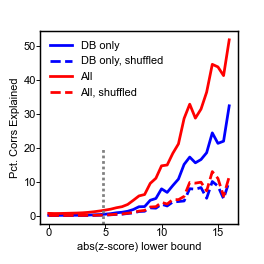

In [65]:
# Plot
def plot_pct_expl(plot_data, rand_type, bc_cutoff, by_cutoff, bh_cutoff):
    plt.figure(figsize=(2, 2), dpi=150)
    plt.plot(plot_data[('db', 'norand')][0],
             plot_data[('db', 'norand')][1],
             label='DB only', color='b', marker='')
    plt.plot(plot_data[('db', rand_type)][0],
             plot_data[('db', rand_type)][1],
             label='DB only, shuffled',
             color='b', linestyle='--', marker='')
    plt.plot(plot_data[('all', 'norand')][0],
             plot_data[('all', 'norand')][1],
             label='All', color='r', marker='')
    plt.plot(plot_data[('all', rand_type)][0],
             plot_data[('all', rand_type)][1],
             label='All, shuffled',
             color='r', linestyle='--', marker='')

    #plt.plot(all_x, all_y, label='All', marker='.')
    #plt.legend(loc='upper left', fontsize=fontsize, frameon=False)
    plt.xlabel('abs(z-score) lower bound')
    plt.ylabel('Pct. Corrs Explained')
    plt.legend(loc='upper left', fontsize=fontsize, frameon=False)
    ax = plt.gca()
    #plt.axvline(x=bc_cutoff, ymin=0, ymax=0.5, linestyle=(0, (1, 1)))
    plt.axvline(x=by_cutoff, ymin=0, ymax=0.4, linestyle=(0, (1, 1)), color='gray')
    #plt.axvline(x=bh_cutoff, ymin=0, ymax=0.5, linestyle=(0, (1, 1)))
    


    format_axis(ax)
    plt.subplots_adjust(left=0.15, bottom=0.15)
    plt.savefig(fig_path(f'pct_expl_corrs_db_vs_all_{rand_type}', 'pdf'))
    plt.savefig(fig_path(f'pct_expl_corrs_db_vs_all_{rand_type}', 'png'))

    
plot_pct_expl(plot_data, 'randxswap', bc_z_cutoff, by_z_cutoff, bh_z_cutoff)

<IPython.core.display.Javascript object>


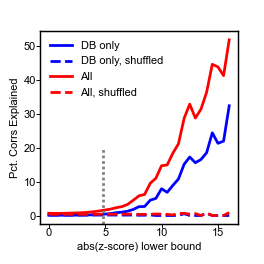

In [66]:
plot_pct_expl(plot_data, 'randlabels', bc_z_cutoff, by_z_cutoff, bh_z_cutoff)

In [68]:
import mplayer
p = mplayer.Player()
success_file = '/Users/johnbachman/Downloads/success.m4a'
p.loadfile(success_file)

Get the stats_df for the explainer and add a column to the explainer indicating whether the pair is in BioGrid or not:

In [69]:
z_cutoff = by_z_cutoff
sdf_list = []
edf_list = []
for (corpus_type, rand_type, lb, ub), expl in explainers.items():
    if corpus_type == 'all' and rand_type == 'norand':
        if ub is not None and ub < z_cutoff:
            continue
        elif lb >= z_cutoff:
            sdf_list.append(expl.stats_df)
            edf_list.append(expl.expl_df)
        else:
            filt_stats = expl.stats_df[expl.stats_df['z_score'] >= z_cutoff]
            filt_expl = expl.expl_df[expl.expl_df['z_score'] >= z_cutoff]
            sdf_list.append(filt_stats)
            edf_list.append(filt_expl)

In [70]:
# Concatenate all the dataframes
sdf = pd.concat(sdf_list, ignore_index=True).set_index('pair')

# Make a set of tuples for comparison to BioGrid
pair_tups = set()
for row in sdf.itertuples():
    pair_tups.add(tuple(sorted([row.agA, row.agB])))
in_bg_tups = pair_tups.intersection(bg_tuples)
in_bg_ix = [f'{t[0]}_{t[1]}' for t in in_bg_tups]

# Add Biogrid column to the dataframe
sdf['in_biogrid'] = False
sdf.loc[in_bg_ix, 'in_biogrid'] = True

# Join the expl_df to the stats_df
sdf_for_join = sdf.drop(['agA', 'agB', 'z_score'], axis=1)
edf = pd.concat(edf_list, ignore_index=True).join(sdf_for_join, on='pair')


Total number of correlations:

In [71]:
len(sdf)

486661

After filtering out the mito correlations:

In [103]:
n_sig_nonmito = len(sdf[sdf['apriori_explained'] == False])
n_sig_nonmito

345077

In [104]:
n_explainable = len(sdf[(sdf['apriori_explained'] == False) &
        ((sdf['reactome_paths'] == True) |
         (sdf['in_biogrid'] == True) |
         (sdf['explained'] == True))])
n_explainable

21475

In [127]:
sdf[(sdf['parent_connections'] == True) &
    (sdf['explained'] == False)]

,agA,agB,z_score,agA_ns,agA_id,agB_ns,agB_id,not_in_graph,explained,a_b,b_a,common_parent,apriori_explained,parent_connections,reactome_paths,in_biogrid
pair,,,,,,,,,,,,,,,,


In [105]:
n_explainable / n_sig_nonmito

0.06223248724197788

Pairs explained only by Reactome pathways:

In [110]:
len(sdf[(sdf['apriori_explained'] == False) &
        (sdf['reactome_paths'] == True) &
         (sdf['in_biogrid'] == False) &
         (sdf['explained'] == False)])

6952

...and pairs in BioGrid:

In [111]:
len(sdf[(sdf['reactome_paths'] == False) &
        (sdf['apriori_explained'] == False) &
        (sdf['in_biogrid'] == False)
       ])

328421

The number of these that we can explain is:

In [112]:
len(sdf[(sdf['reactome_paths'] == False) &
        (sdf['apriori_explained'] == False) &
        (sdf['in_biogrid'] == False) &
        (sdf['explained'] == True)])

4819

In [113]:
expl_sets = {}
for expl_type, expl_label in (('reactome_paths', 'Reactome pathways'),
                  ('in_biogrid', 'BioGrid interactions'),
                  ('explained', 'INDRA network')):
    expl_sets[expl_label] = set(sdf[(sdf['apriori_explained'] == False) &
                               (sdf[expl_type] == True)].index)

<IPython.core.display.Javascript object>


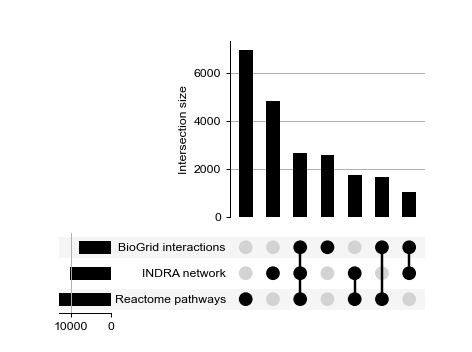

In [173]:
upset_df = upsetplot.from_contents(expl_sets)
upset_fig = plt.figure()
upsetplot.plot(upset_df, fig=upset_fig, sort_by='cardinality')
# Plot a linear scale version
#upset_fig.savefig(fig_path('overlap_upset_linear', 'pdf'))
# Plot a log scale version
#upset_fig.gca().set_yscale('log')
upset_fig.savefig(fig_path('expl_indra_rxm_bg', 'pdf'))

In [176]:
expl_indra_sets = {}
for expl_type, expl_label in (('a_b', 'Direct'),
                              ('b_a', 'Direct'),
                              ('common_parent', 'Family/Cplx'),
                              ('parent_connections', 'Parent Link')):
    if expl_type in ('a_b', 'b_a'):
        expl_indra_sets[expl_label] = set(sdf[(sdf['apriori_explained'] == False) &
                                              (sdf['reactome_paths'] == False) &
                                              (sdf['in_biogrid'] == False) &
                                              ((sdf['a_b'] == True) | (sdf['b_a'] == True))].index)        
    else:
        expl_indra_sets[expl_label] = set(sdf[(sdf['apriori_explained'] == False) &
                                              (sdf['reactome_paths'] == False) &
                                              (sdf['in_biogrid'] == False) &
                                              (sdf[expl_type] == True)].index)

<IPython.core.display.Javascript object>


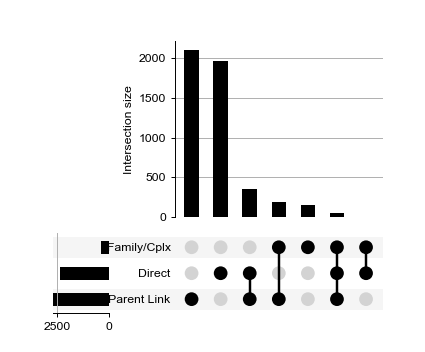

In [177]:
upset_df = upsetplot.from_contents(expl_indra_sets)
upset_fig = plt.figure()
upsetplot.plot(upset_df, fig=upset_fig, sort_by='cardinality')
upset_fig.savefig(fig_path('expl_indra_subtype', 'pdf'))

In [168]:
len(expl_indra_sets['Parent link'])

2703

In [193]:
pc_only = set(sdf[(sdf['apriori_explained'] == False) &
        (sdf['reactome_paths'] == False) &
        (sdf['in_biogrid'] == False) &
        (sdf['a_b'] == False) &
        (sdf['b_a'] == False) &
        (sdf['common_parent'] == False) &
        (sdf['parent_connections'] == True)].index)

In [194]:
edf[edf.pair.isin(pc_only)][0:50]

,pair,agA,agB,z_score,expl_type,expl_data,agA_ns,agA_id,agB_ns,agB_id,...,explained,a_b,b_a,common_parent,apriori_explained,parent_connections,reactome_paths,in_biogrid,max_belief,reading_only
2862,SYVN1_UBE2G2,SYVN1,UBE2G2,14.492168,parent_connections,{'SYVN1_op': {'SYVN1_UBE2': {'statements': [{'...,HGNC,20738,HGNC,12483,...,True,False,False,False,False,True,False,False,0,NaN
3955,MPRIP_ROCK2,MPRIP,ROCK2,-12.810335,parent_connections,{'MPRIP_op': {'MPRIP_ROCK': {'statements': [{'...,HGNC,30321,HGNC,10252,...,True,False,False,False,False,True,False,False,0,NaN
4050,NCKAP1_YES1,NCKAP1,YES1,12.922570,parent_connections,{'NCKAP1_op': {'NCKAP1_SRC': {'statements': [{...,HGNC,7666,HGNC,12841,...,True,False,False,False,False,True,False,False,0,NaN
4223,TLN1_YES1,TLN1,YES1,12.528886,parent_connections,{'TLN1_op': {'TLN1_SRC': {'statements': [{'stm...,HGNC,11845,HGNC,12841,...,True,False,False,False,False,True,False,False,0,NaN
4334,CCNK_PSMC1,CCNK,PSMC1,12.140980,parent_connections,{'sp_op': {'Cyclin_Proteasome': {'statements':...,HGNC,1596,HGNC,9547,...,True,False,False,False,False,True,False,False,0,NaN
4761,PAX8_PRKCI,PAX8,PRKCI,12.414380,parent_connections,{'PAX8_op': {'PKC_PAX8': {'statements': [{'stm...,HGNC,8622,HGNC,9404,...,True,False,False,False,False,True,False,False,0,NaN
4962,CCNI_TP53,CCNI,TP53,-11.888149,parent_connections,{'TP53_sp': {'Cyclin_TP53': {'statements': [{'...,HGNC,1595,HGNC,11998,...,True,False,False,False,False,True,False,False,0,NaN
5611,SMARCD1_TADA2B,SMARCD1,TADA2B,11.692346,parent_connections,{'TADA2B_sp': {'SWI_SNF_TADA2B': {'statements'...,HGNC,11106,HGNC,30781,...,True,False,False,False,False,True,False,False,0,NaN
5624,TP53_UBE2D3,TP53,UBE2D3,-11.917190,parent_connections,{'TP53_op': {'UBE2_TP53': {'statements': [{'st...,HGNC,11998,HGNC,12476,...,True,False,False,False,False,True,False,False,0,NaN
5869,DHH_VDR,DHH,VDR,11.145499,parent_connections,{'VDR_sp': {'Hedgehog_VDR': {'statements': [{'...,HGNC,2865,HGNC,12679,...,True,False,False,False,False,True,False,False,0,NaN


In [189]:
mprip_rock = edf.iloc[3955].expl_data

In [197]:
direct = set(sdf[(sdf['apriori_explained'] == False) &
        (sdf['reactome_paths'] == False) &
        (sdf['in_biogrid'] == False) &
        ((sdf['a_b'] == True) |
         (sdf['b_a'] == True)) &
        (sdf['common_parent'] == False) &
        (sdf['parent_connections'] == False)].index)

BRAF-MITF cherry-pick

In [203]:
braf_mitf_hashes = set([ed['stmt_hash'] for ed in edf.iloc[139].expl_data])
mitf_braf_hashes = set([ed['stmt_hash'] for ed in edf.iloc[140].expl_data])
braf_mitf_all_hashes = list(braf_mitf_hashes.union(mitf_braf_hashes))

In [205]:
len(braf_mitf_all_hashes)

20

In [216]:
braf_mitf_stmts = [s for s in tqdm(all_stmts) if s.get_hash() in braf_mitf_all_hashes]

100%|██████████| 814991/814991 [00:01<00:00, 756712.15it/s]


In [218]:
len([ev for stmt in braf_mitf_stmts for ev in stmt.evidence])

59

"More obscure" cherry-pick:

In [222]:
edf['abs_z_score'] = abs(edf['z_score'])

In [224]:
novel_direct = edf[edf.pair.isin(direct)].sort_values(by='abs_z_score', ascending=True)

In [225]:
def max_belief(series):
    ix_list = []
    mb_list = []
    for ix, expl_data in series.iteritems():
        max_bel = max([d['belief'] for d in expl_data])
        mb_list.append(max_bel)
        ix_list.append(ix)
    return ix_list, mb_list

ix, mb = max_belief(novel_direct.expl_data)
novel_direct.loc[ix, 'max_belief'] = mb

In [229]:
def reading_only(series):
    readers = set(['reach', 'sparser', 'medscan', 'rlimsp', 'trips'])
    ix_list = []
    ro_list = []
    for ix, expl_data in series.iteritems():
        all_sources = set()
        for expl_stmt in expl_data:
            all_sources |= set(expl_stmt['source_counts'].keys())
        is_ro = True if all_sources < readers else False
        ix_list.append(ix)
        ro_list.append(is_ro)
    return ix_list, ro_list

ix, ro = reading_only(novel_direct.expl_data)
novel_direct.loc[ix, 'reading_only'] = ro

In [233]:
ndro = novel_direct[novel_direct['reading_only'] == True]

In [236]:
ndro.sort_values(by='abs_z_score', ascending=False).sort_values(by='max_belief', ascending=True)[0:50]

,pair,agA,agB,z_score,expl_type,expl_data,agA_ns,agA_id,agB_ns,agB_id,...,a_b,b_a,common_parent,apriori_explained,parent_connections,reactome_paths,in_biogrid,max_belief,reading_only,abs_z_score
68661,GDF15_IL10,GDF15,IL10,5.221769,a_b,"[{'stmt_hash': 10141426769164743, 'stmt_type':...",HGNC,30142,HGNC,5962,...,True,True,False,False,False,False,False,0.066908,True,5.221769
68662,GDF15_IL10,IL10,GDF15,5.221769,b_a,"[{'stmt_hash': 10141426769164743, 'stmt_type':...",HGNC,30142,HGNC,5962,...,True,True,False,False,False,False,False,0.066908,True,5.221769
64398,CTLA4_EGFR,CTLA4,EGFR,-5.248130,a_b,"[{'stmt_hash': -21556060120147478, 'stmt_type'...",HGNC,2505,HGNC,3236,...,True,True,False,False,False,False,False,0.074723,True,5.248130
33462,ATXN2_SH2B3,SH2B3,ATXN2,6.063420,b_a,"[{'stmt_hash': 24398310070954638, 'stmt_type':...",HGNC,10555,HGNC,29605,...,True,True,False,False,False,False,False,0.074723,True,6.063420
64399,CTLA4_EGFR,EGFR,CTLA4,-5.248130,b_a,"[{'stmt_hash': -21556060120147478, 'stmt_type'...",HGNC,2505,HGNC,3236,...,True,True,False,False,False,False,False,0.074723,True,5.248130
33461,ATXN2_SH2B3,ATXN2,SH2B3,6.063420,a_b,"[{'stmt_hash': 24398310070954638, 'stmt_type':...",HGNC,10555,HGNC,29605,...,True,True,False,False,False,False,False,0.074723,True,6.063420
40983,S1PR3_SHC3,S1PR3,SHC3,6.056670,a_b,"[{'stmt_hash': 16073859272329148, 'stmt_type':...",HGNC,3167,HGNC,18181,...,True,True,False,False,False,False,False,0.098535,True,6.056670
40984,S1PR3_SHC3,SHC3,S1PR3,6.056670,b_a,"[{'stmt_hash': 16073859272329148, 'stmt_type':...",HGNC,3167,HGNC,18181,...,True,True,False,False,False,False,False,0.098535,True,6.056670
26234,ANO1_PPFIA1,ANO1,PPFIA1,6.547313,a_b,"[{'stmt_hash': -5538698252431116, 'stmt_type':...",HGNC,21625,HGNC,9245,...,True,True,False,False,False,False,False,0.098535,True,6.547313
26235,ANO1_PPFIA1,PPFIA1,ANO1,6.547313,b_a,"[{'stmt_hash': -5538698252431116, 'stmt_type':...",HGNC,21625,HGNC,9245,...,True,True,False,False,False,False,False,0.098535,True,6.547313


In [241]:
ndro.loc[5702].expl_data

[{'stmt_hash': -14822291484484941,
  'stmt_type': 'Complex',
  'evidence_count': 2,
  'belief': 0.09853540334496423,
  'source_counts': {'sparser': 2},
  'curated': False,
  'weight': 2.31733937055975,
  'initial_sign': None,
  'position': None,
  'residue': None,
  'english': 'BCAR1 binds DOCK5.'}]

In [115]:
#venn_subplot = venn(expl_sets, fmt='{percentage:.2f}')
#venn_subplot.figure.savefig(fig_path('overlap_venn_pcts', 'pdf'))

Looking at explanations, add column for max belief for entries with direct explanations:

In [122]:
edf['max_belief'] = 0
edf['reading_only'] = float('nan')

How many total unique correlations explained this way?

Set the max_belief column:

Add in a field for whether the explanations are from reading only:

The parent connections-only explanations:

In [157]:
edf[edf.pair.isin(pc_only)].sort_values(by='max_belief', ascending=False)[0:50]

,pair,agA,agB,z_score,expl_type,expl_data,agA_ns,agA_id,agB_ns,agB_id,...,explained,a_b,b_a,common_parent,apriori_explained,parent_connections,reactome_paths,in_biogrid,max_belief,reading_only
2862,SYVN1_UBE2G2,SYVN1,UBE2G2,14.492168,parent_connections,{'SYVN1_op': {'SYVN1_UBE2': {'statements': [{'...,HGNC,20738,HGNC,12483,...,True,False,False,False,False,True,False,False,0,NaN
69990,HNRNPK_PSMB6,HNRNPK,PSMB6,5.487973,parent_connections,{'HNRNPK_op': {'Proteasome_HNRNPK': {'statemen...,HGNC,5044,HGNC,9543,...,True,False,False,False,False,True,False,False,0,NaN
69944,HMGCR_PSMD1,HMGCR,PSMD1,5.043617,parent_connections,{'HMGCR_op': {'Proteasome_HMGCR': {'statements...,HGNC,5006,HGNC,9554,...,True,False,False,False,False,True,False,False,0,NaN
69925,HMGA1_MMP3,HMGA1,MMP3,-5.010097,parent_connections,{'HMGA1_op': {'HMGA1_MMP': {'statements': [{'s...,HGNC,5010,HGNC,7173,...,True,False,False,False,False,True,False,False,0,NaN
69916,HLA-DRA_HSPA1L,HLA-DRA,HSPA1L,5.167089,parent_connections,{'sp_op': {'HLA_DR_HSPA': {'statements': [{'st...,HGNC,4947,HGNC,5234,...,True,False,False,False,False,True,False,False,0,NaN
69901,HJURP_MAD2L1,HJURP,MAD2L1,5.017623,parent_connections,{'HJURP_op': {'HJURP_Kinetochore': {'statement...,HGNC,25444,HGNC,6763,...,True,False,False,False,False,True,False,False,0,NaN
69861,HGF_YES1,HGF,YES1,-5.106066,parent_connections,{'HGF_op': {'HGF_SRC': {'statements': [{'stmt_...,HGNC,4893,HGNC,12841,...,True,False,False,False,False,True,False,False,0,NaN
69859,HGF_MMP20,HGF,MMP20,5.287005,parent_connections,{'HGF_op': {'HGF_MMP': {'statements': [{'stmt_...,HGNC,4893,HGNC,7167,...,True,False,False,False,False,True,False,False,0,NaN
69849,HEXIM1_PSMD9,HEXIM1,PSMD9,5.420316,parent_connections,{'HEXIM1_op': {'Proteasome_HEXIM1': {'statemen...,HGNC,24953,HGNC,9567,...,True,False,False,False,False,True,False,False,0,NaN
69843,HES4_VEGFB,HES4,VEGFB,5.242092,parent_connections,{'sp_op': {'HES_VEGF': {'statements': [{'stmt_...,HGNC,24149,HGNC,12681,...,True,False,False,False,False,True,False,False,0,NaN


In [155]:
edf[edf['pair'] == 'NCKAP1_YES1'].expl_data.values[0:100

{'NCKAP1_op': {'NCKAP1_SRC': {'statements': [{'stmt_hash': -27547728786465563,
     'stmt_type': 'Activation',
     'evidence_count': 1,
     'belief': 0.3806090344185226,
     'source_counts': {'reach': 1},
     'curated': False,
     'weight': 0.9659825870961838,
     'initial_sign': None,
     'position': None,
     'residue': None,
     'english': 'NCKAP1 activates SRC.'}],
   'belief': 0.3806090344185226182,
   'weight': 0.96598258709618373656}}}

In [209]:
nov_dir_ro = novel_dir[novel_dir.reading_only == True][['pair', 'z_score', 'max_belief', 'expl_type', 'expl_data']]

In [214]:
len(nov_dir_ro.pair.unique())

1673

Get the subset of these explained by parent connections:

In [119]:
novel_dir = novel[(novel['expl_type'] == 'a_b') |
                  (novel['expl_type'] == 'b_a')]

In [211]:
nov_dir_ro.sort_values(by='z_score', ascending=False)[0:50]

,pair,z_score,max_belief,expl_type,expl_data
1420,SCAP_SCD,28.542887,0.146028,b_a,"[{'stmt_hash': -495617213965584, 'stmt_type': ..."
1419,SCAP_SCD,28.542887,0.146028,a_b,"[{'stmt_hash': -495617213965584, 'stmt_type': ..."
662,MITF_SOX10,23.759936,0.504795,a_b,"[{'stmt_hash': 9065193758515369, 'stmt_type': ..."
568,MDM4_PPM1D,23.473889,0.860384,b_a,"[{'stmt_hash': -4641918109788224, 'stmt_type':..."
567,MDM4_PPM1D,23.473889,0.146028,a_b,"[{'stmt_hash': -6270783202076742, 'stmt_type':..."
141,BRAF_SOX10,21.767325,0.555592,a_b,"[{'stmt_hash': -8034462096396835, 'stmt_type':..."
1537,UFL1_UFM1,21.706376,0.536266,b_a,"[{'stmt_hash': -29033663116008959, 'stmt_type'..."
1536,UFL1_UFM1,21.706376,0.536266,a_b,"[{'stmt_hash': -29033663116008959, 'stmt_type'..."
444,FOXA1_SPDEF,21.154441,0.627571,a_b,"[{'stmt_hash': -28848742829388504, 'stmt_type'..."
445,FOXA1_SPDEF,21.154441,0.380609,b_a,"[{'stmt_hash': -13084909409799942, 'stmt_type'..."


In [ ]:
nov_dir_ro.loc[2108].expl_data

Open the files dumped by the script above to get the DepMapExplainer objects:

In [ ]:
dme_db.stats_df[dme_db.stats_df['explained'] == True]

In [ ]:
dme_all.stats_df[dme_all.stats_df['explained'] == True]

Plot max belief score vs. pair correlation

In [ ]:
dme_all.stats_df.shape

In [ ]:
zsc_all = dme_all.stats_df[dme_all.stats_df['explained'] == True].z_score.abs()
zsc_db = dme_db.stats_df[dme_db.stats_df['explained'] == True].z_score.abs()

In [ ]:
fig = plt.figure(figsize=(2, 2), dpi=150)
ax = plt.gca()
sns.histplot(zsc_all, stat='count', element='poly', color='blue', ax=ax, fill=False, label='All')
sns.histplot(zsc_db, stat='count', element='poly', color='red', ax=ax, fill=False, label='DB only')
plt.legend(loc='upper right', fontsize=7, frameon=False)
plt.title('Number of explained correlations', fontsize=7)
format_axis(ax)
plt.subplots_adjust(left=0.18)
plt.savefig(fig_path('num_expl_corrs_db_vs_all', 'pdf'))
#sns.displot(zsc_db, color='red')
#sns.distplot(zsc_db)

In [ ]:
dme_all_pair = dme_all.stats_df.set_index('pair').drop(['agA', 'agB', 'z_score'], axis=1)
dme_all_df = dme_all.expl_df.join(dme_all_pair, on='pair')

In [ ]:
counter = 0
expl_summary = []
for gb_key, gb_df in tqdm(dme_all.expl_df.groupby('pair')):
    all_beliefs = []
    ev_ct = 0
    num_stmts = 0
    stmt_types = set()
    only_cp = True
    for row in gb_df.itertuples():
        if row.expl_type in ('a_b', 'b_a'):
            num_stmts += len(row.expl_data)
            for stmt_info in row.expl_data:
                ev_ct += stmt_info['evidence_count']
                stmt_types.add(stmt_info['stmt_type'])
                stmt = stmts_by_hash[stmt_info['stmt_hash']]
                all_beliefs.append(stmt.belief)
                z_score = row.z_score
            only_cp = False
    if only_cp:
        continue
    max_belief = np.max(all_beliefs)
    avg_belief = np.mean(all_beliefs)
    pair_info = {'pair': gb_key,
                 'num_stmts': num_stmts,
                 'ev_ct': ev_ct,
                 'num_stmt_types': len(stmt_types),
                 'max_belief': np.max(all_beliefs),
                 'avg_belief': np.mean(all_beliefs),
                 'z_score': z_score,
                 'abs_z_score': abs(z_score),
                }
    expl_summary.append(pair_info)

In [ ]:
dme_all_df.columns

In [ ]:
dme_all_sum_df = pd.DataFrame.from_records(expl_summary, index='pair')

In [ ]:
fig = plt.figure(figsize=(2, 2), dpi=150)
sns.scatterplot(x='abs_z_score', y='ev_ct', data=dme_all_sum_df, s=1.5)
ax = plt.gca()
ax.set_yscale('log')
plt.subplots_adjust(left=0.15, bottom=0.15)
format_axis(ax)

In [ ]:
dme_all_sum_df.corr()


In [ ]:
dasd = dme_all_sum_df

In [ ]:
dasd[dasd['max_belief'] < 0.25].sort_values('abs_z_score', ascending=False)

In [ ]:
dme_all

In [ ]:
plt.gca()

In [ ]:
pos_types = set(['Activation', 'IncreaseAmount'])
neg_types = set(['Inhibition', 'DecreaseAmount'])

mitocarta = pd.read_excel('../../depmap_analysis/notebooks/data/Human.MitoCarta3.0.xls', sheet_name=1)
mitogenes = list(mitocarta.Symbol.values)

def get_expl_stats(dme):
    # Iterate over explanations for pair
    stats = dme.stats_df.set_index('pair')
    expl_summary = []
    expl_hashes = {}
    for gb_key, gb_df in tqdm(dme.expl_df.groupby('pair')):
        # Skip mitochondrial correlations
        agA, agB = gb_key.split('_')
        if agA in mitogenes or agB in mitogenes:
            continue
        pair_hashes = set()
        for row in gb_df.itertuples():
            for stmt_info in row.expl_data:
                pair_hashes.add(stmt_info['stmt_hash'])
        expl_hashes[gb_key] = pair_hashes
        corr = stats.loc[gb_key].z_score
        stmts = [stmts_by_hash[h] for h in pair_hashes]
        stmt_types = set([s.__class__.__name__ for s in stmts])
        # Check only positive types
        if not stmt_types.difference(pos_types):
            sign = 'positive'
        # Check only negative types
        elif not stmt_types.difference(neg_types):
            sign = 'negative'
        else:
            sign = 'mixed'
        expl_summary.append((gb_key, corr, len(pair_hashes), list(pair_hashes), sign, stmts))
    return expl_summary

In [ ]:
expl_db = get_expl_stats(dme_db)

In [ ]:
expl_all = get_expl_stats(dme_all)

In [ ]:
pairs, z_scores, num_stmts, hashes, sign, stmts = zip(*expl_all)

In [ ]:
len(expl_db)

In [ ]:
len(expl_all)

In [ ]:
expl = [e for e in expl_all if e[2] >200]

In [ ]:
[stmts_by_hash[h] for h in expl[0][3]]

In [ ]:
def rand_jitter(arr, jitter=0.01):
    stdev = jitter * (max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

plt.figure()
pos = [e for e in expl_all if e[4] == 'positive']
neg = [e for e in expl_all if e[4] == 'negative']
mixed = [e for e in expl_all if e[4] == 'mixed']

points = [(mixed, 'gray'), (pos, 'red'), (neg, 'blue')]
for data, color in points:
    plt.plot([t[1] for t in data],
             rand_jitter([t[2] for t in data], jitter=0.1),
             linestyle='', marker='.', markersize=3, color=color, alpha=0.2)
plt.ylim(0, 5)

In [ ]:
contra = [expl for expl in expl_all if (expl[1] < 0 and expl[4] == 'positive') or
                                       (expl[1] > 0 and expl[4] == 'negative')]
contra.sort(key=lambda x: abs(x[1]), reverse=True)

In [ ]:
len(contra)

In [ ]:
list(zip(range(len(contra)), contra))

In [ ]:
contra[9]

In [ ]:
contra[9][-1][0].evidence

In [11]:
top = ac.filter_top_level(kge_stmts)
not_top = [s for s in kge_stmts if s not in top]

INFO: [2021-07-14 17:06:26] indra.tools.assemble_corpus - Filtering 1689 statements for top-level...
INFO: [2021-07-14 17:06:26] indra.tools.assemble_corpus - 1198 statements after filter...


In [236]:
samp = random.sample(stmts_y, 20)
kge_samp, y_samp = list(zip(*samp))

In [207]:
small_stmts_y = [(s, y) for s, y in zip(kge_samp, y_samp) if len(s.evidence) <= 10]

In [246]:
def total_ev(stmt):
    return sum([len(s.evidence) for s in ([stmt] + stmt.supports + stmt.supported_by)])

In [256]:
for ix, (s, y) in enumerate(small_stmts_y):
    print(ix, len(s.evidence), total_ev(s), s)

0 10 10 Complex(XPNPEP2(), COMT())
1 2 2 Inhibition(ARF1(), GBF1())
2 4 5 IncreaseAmount(TP53(), NGFR())
3 7 234 Phosphorylation(JAK3(), EZH2())
4 2 2 Complex(TGFA(), HGF())
5 2 2 Activation(ERK(), KLF6())
6 8 10 Activation(CCR7(), AKT())
7 1 1 Activation(PAPPA(), RUNX2())
8 3 3 Complex(HMGCL(), POU2F1())
9 5 5 Complex(PDCD6IP(), PTK2())
10 3 210 Phosphorylation(STK3(), PPARG())
11 1 434 Phosphorylation(MAPK14(), RPS6KA5(), T, 700)
12 9 17 Acetylation(MCM3AP(), MCM3())
13 1 1 Activation(NCOA3(), EIF2AK3())
14 1 125 Phosphorylation(CDC14A(), WEE1(), S, 123)
15 2 274 Complex(CBL(), EGFR(activity))
16 1 61 Deacetylation(SIRT1(), FOXO1(mods: (acetylation)))
17 1 2 Complex(TNFRSF17(), TRAF5())
18 1 66 Phosphorylation(EGF(), IQGAP1(), Y)
19 9 11 Activation(VCL(), FAS())
20 3 3 Complex(EIF4G(), EIF4E2())
21 7 7 Activation(CYTH2(), RRAS())
22 9 9 Complex(VCP(), DERL1())
23 3 1150 Phosphorylation(SRC(), BCAR1(), Y, 165)
24 1 931 Phosphorylation(CSNK2B(), CSNK2B(), S, 209)
25 6 38 Phosphorylatio

In [254]:
exclude = [ 3, 10, 11, 14, 15, 23, 24, 27, 33, 38, 49, 59, 61, 63, 64, 70]

In [255]:
small_stmts_y_filt = [s for ix, s in enumerate(small_stmts_y) if ix not in exclude]

In [288]:
small_stmts, small_y = zip(*small_stmts_y_filt)

In [289]:
top = ac.filter_top_level(small_stmts)
not_top = [s for s in small_stmts if s not in top][5:10]

INFO: [2021-05-07 22:48:09] indra.tools.assemble_corpus - Filtering 57 statements for top-level...
INFO: [2021-05-07 22:48:09] indra.tools.assemble_corpus - 47 statements after filter...


In [290]:
subsamp = random.sample(top, 5)

In [291]:
final_samp_y = [(s, y) for s, y in small_stmts_y if s in not_top or s in subsamp]

In [292]:
len(final_samp_y)

10

In [293]:
small_stmts, small_y = zip(*final_samp_y)

In [294]:
import json
from indra.statements import stmts_to_json, stmts_from_json

with open('/Users/johnbachman/Desktop/test_stmts_cur_samp.pkl', 'wb') as f:
    pickle.dump((small_stmts, small_y), f)
    
with open('/Users/johnbachman/Desktop/test_stmts_cur_samp.json', 'w') as f:
    json.dump(stmts_to_json(list(small_stmts)), f)


In [214]:
ev_ctr = [len(s.evidence) for s in small_stmts]

In [225]:
from indra.statements import stmts_to_json, stmts_from_json

with open('/Users/johnbachman/Desktop/test_stmts_cur_samp.json', 'r') as f:
    stmt_json = json.load(f)
    foo = stmts_from_json(stmt_json)

In [227]:
top = ac.filter_top_level(foo)

INFO: [2021-05-07 20:54:42] indra.tools.assemble_corpus - Filtering 73 statements for top-level...
INFO: [2021-05-07 20:54:42] indra.tools.assemble_corpus - 59 statements after filter...


In [228]:
not_top = [s for s in foo if s not in top]

In [231]:
not_top[0].supports

[Unresolved(uuid=48366ece-574d-4c24-b175-96f33ba9be51)]

In [186]:
arr1 = np.array([1, 2])
arr2 = np.array([1, 3])
np.all(np.greater_equal(arr2, arr1))

True